In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

import itertools
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
stop_words = stopwords.words('english') + \
            ['et', 'al', 'fig', 'figs', 'figure', 'table', 'also',
            'using', 'found', 'observed', 'however', 'previous', 'study',
            'although', 'studies', 'several', 'showed', 'could', 
            'performed', 'known', 'methods', 'whether', 'materials',
            'known', 'analyzed', 'within', 'show', 'respectively', 
            'thus', 'therefore', 'tested', 'among', 'abstract', 
            'introduction', 'may', 'shown', 'results', 'interestingly',
            'either', 'similarly', 'furthermore', 'consistently', 
            'neither', 'one', 'two', 'three', 'four', 'five', 'six',
            'seven', 'eigh', 'nine', 'ten', 'eleven', 'twelve', 
            'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
            'eighteen', 'nineteen', 
            'supplemental', 'almost', 'generally', 'underlying', 'play',
            'pivotal', 'remain', 'whose',
            'finally' , 'name', 'albeit', 'notably', 'corresponding', 'used', 'obtained', 'total', 'panel', 'seen',
'left', 'right', 'another', 'ability', 'significantly', 'upon', 'observations', 'detecting', 'unveil',
'hypothesized', 'yet', 'whereas', 'capture', 'middle', 'determined', 'added', 'amounts', 'visualized',
'bottom', 'involved', 'aim', 'highly', 'specific', 'caused', 'marked', 'suggest', 'expected', 'combined', 
'wished', 'explore', 'hypothesis', 'dramatically', 'involves', 'verified', 'proper', 'existence',
'finding', 'establish', 'direct', 'previously', 'mediated', 'remained', 'directly', 'studied', 'indeed',
'individual', 'robustly', 'suggests', 'important', 'supported', 'seem', 'judged', 'much', 'hence',
'regardless', 'must', 'seems', 'findings', 'achieved', 'offer', 'explanation', 'already', 'evidence',
'reported', 'bring', 'usual', 'so-called', 'fashion', 'especially', 'would', 'allow', 'require', 'present',
'first', 'frequently', 'many', 'contribute', 'understanding', 'causing', 'like', 'third', 
'interesting', 'showing', 'various', 'certain', 'particular', 'general', 'described', 'according',
'manufacturers', 'instructions', 'scientific', 'content', 'times', 'page', 'onto', 'processed',
'standard', 'procedures', 'following', 'primary', 'biotechnology', 'generated', 'system', 'provider',
'infected', 'infection', 'time', 'see', 'supplementary', 'note', 'online', 'authors',
'noted', 'represented', 'define', 'apparent', 'appearance', 'cases', 'recognizable', 'case', '4th', '5th',
'right', 'compare', 'picture', 'data', 'log2', 'represents', 'full', 'ref',
'high-resolution', 'real-time', 'defined', 'find', 'proven', 'routine', 'databases', 'literature',
'remaining', 'affecting',
             'whose', 'elusive', 'reveal', 'plays', 'ago', 'others', 'presents', 'correspond', 
'corresponds', 'examined', 'detected', 'straightforward', 'reproducible', 'relevance',
'demonstrating', 'suggested', 'exhibited', 'suggesting', 'likely', 
 #           'mutation', 'cell', 'mutations', 'cells',
            ]


In [3]:
sp  = re.compile(r'(?<!-)\b(' + r'|'.join(stop_words) + r')\b(?!-)\s*')
s = sp.sub(' x ', 'a Fromage amk ia hla-a a one I a i one 2a')
#s = sp.sub(' x ', s)
s

' x Fromage amk ia hla-a  x  x I  x  x  x 2a'

In [4]:
#stop_pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
stop_pattern = re.compile(r'(?<!-)\b(' + r'|'.join(stopwords.words('english')+stop_words) + r')\b(?!-)\s*')

def get_cleaned_text(fname, max_len=999999):
    all_words = []
    with open(fname, 'r') as f:
        for n, line in enumerate(f):
            if n and n<max_len:
                line_id, line_text = line.split('||')
                # this regex should remove all the lone numbers, i.e, numbers that are not part of words
                #line_text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", line_text) 
                line_text = re.sub(r"(?<!-)\b\d+\b", " ", line_text)
                # keep letters, numbers and a few characters that are seen in words;
                # substitute other characters with a space
                line_text = re.sub("[^\w\-\*\_]", " ", line_text)
                #line_text = re.sub("[\s.,()\'\`\"\’\‘]", " ", line_text)
                #print(line_text)        
                #line_text = re.sub("[^\w\-\*\_]", " ", line_text)

                line_letters_low = line_text.lower()
                line_letters_low = stop_pattern.sub(' ', line_letters_low)
                line_words = line_letters_low.split()
                line_words = [s for s in line_words if len(s) > 2]
                all_words.append(line_words)
                #all_words.append(line_letters_low)
                #print(len(all_words), len(line_letters_low))
    return all_words

In [5]:
def get_wv():
    fname = '../data/training_text'
    train_text = get_cleaned_text(fname)
    fname = '../data/test_text'
    test_text = get_cleaned_text(fname)
    test_text.extend(train_text)
    
    w2v_model = Word2Vec(test_text, size=200, window=5, min_count=3, workers=4, iter=10)
    return w2v_model

In [6]:
w2v_model = get_wv()

In [7]:
w2v_model.wv['fam58a']
w2v_model.wv.most_similar(positive='gene')

[('genes', 0.7760730981826782),
 ('locus', 0.5549212098121643),
 ('loci', 0.4593113660812378),
 ('oncogene', 0.4497154951095581),
 ('genomic', 0.43881237506866455),
 ('mrna', 0.43674013018608093),
 ('intragenic', 0.4323493242263794),
 ('chromosome', 0.43178126215934753),
 ('11p15', 0.429840087890625),
 ('oncogenes', 0.4268164038658142)]

In [8]:
def get_feature_vector(fname_text, variants):
    text = get_cleaned_text(fname_text)

    text_wv_mean = np.empty(shape=(len(text), w2v_model.layer1_size))
    gene_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    vari_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    for i, text in enumerate(text):
        # as a first approximation, let's estimate the mean vector of each text;
        # for later TODO some fancy projections
        text_wv_mean[i, :] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)
        if variants['Gene'][i] in w2v_model.wv.vocab:
            gene_wv_mean[i, :] = w2v_model.wv[variants['Gene'][i].lower()]
        # some parsing of the variation names will be good
        if variants['Variation'][i] in w2v_model.wv.vocab:
            vari_wv_mean[i, :] = w2v_model.wv[variants['Variation'][i].lower()]
    return np.concatenate((text_wv_mean, gene_wv_mean, vari_wv_mean), axis=1)


train_variants = pd.read_csv('../data/training_variants')
fvec = get_feature_vector('../data/training_text', train_variants)
fvec.shape

(3321, 600)

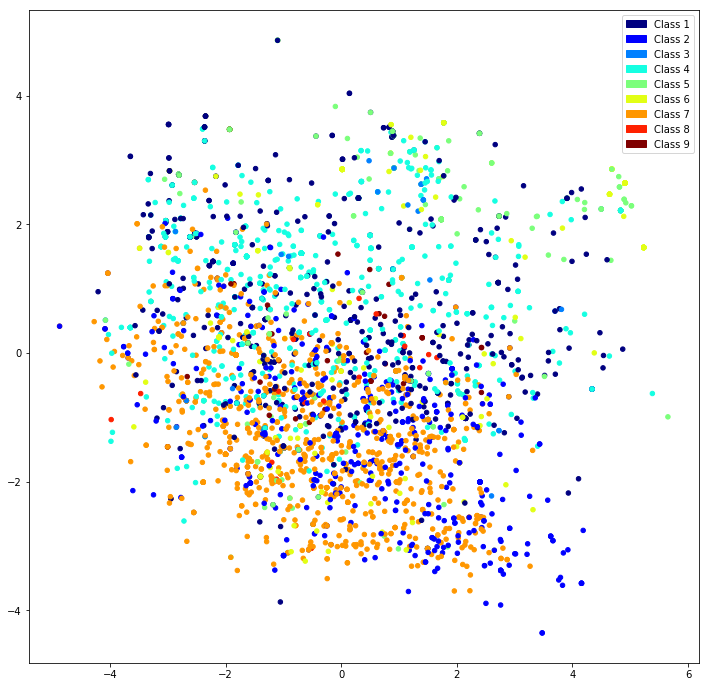

In [9]:
from matplotlib.patches import Patch

pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(fvec)
classes = train_variants.Class.values

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=20)
#plt.legend(['Class ' +str(i+1) for i in range(9)])
plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

In [10]:
forest = RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.86260574898
[ 0.41071429  0.45535714  0.41317365  0.44144144  0.34834835  0.43975904
  0.56193353  0.62121212  0.57142857  0.44648318]
Accuracy: 0.47 (+/- 0.08)


In [11]:
forest = RandomForestClassifier(n_estimators=20, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.861479928347
[ 0.38988095  0.42857143  0.41916168  0.4024024   0.3033033   0.40963855
  0.46223565  0.61818182  0.57446809  0.43425076]
Accuracy: 0.44 (+/- 0.09)


In [12]:
forest = RandomForestClassifier(n_estimators=50, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.863964304422
[ 0.44047619  0.42261905  0.45209581  0.43243243  0.34234234  0.45180723
  0.5407855   0.62727273  0.60182371  0.43425076]
Accuracy: 0.47 (+/- 0.08)


In [13]:
forest = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.862660786558
[ 0.43452381  0.45833333  0.45508982  0.42342342  0.35735736  0.43975904
  0.5407855   0.63333333  0.58358663  0.43425076]
Accuracy: 0.48 (+/- 0.08)


In [14]:
forest = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.863296082987
[ 0.46130952  0.44940476  0.41017964  0.44744745  0.33033033  0.44578313
  0.57099698  0.61515152  0.58358663  0.43425076]
Accuracy: 0.47 (+/- 0.08)


In [20]:
forest = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.862588870848
[ 0.42261905  0.46130952  0.47904192  0.44444444  0.32432432  0.46084337
  0.5407855   0.63030303  0.57446809  0.44036697]
Accuracy: 0.48 (+/- 0.08)


In [16]:
forest = RandomForestClassifier(n_estimators=500, n_jobs=2) 
forest = forest.fit(fvec, train_variants["Class"])

result_tr = forest.predict(fvec)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, fvec, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.87604271922
[ 0.41964286  0.45833333  0.4760479   0.43243243  0.34234234  0.4246988
  0.51359517  0.61515152  0.58054711  0.44648318]
Accuracy: 0.47 (+/- 0.08)


In [43]:
#test_text = get_cleaned_text(fname)
test_variants = pd.read_csv('../data/test_variants')
fvec_test = get_feature_vector('../data/test_text', test_variants)


In [44]:
result = forest.predict(fvec_test)
result_mat = np.zeros((len(result), 9))
    
test_id = np.arange(len(result))

result_mat[test_id, result-1] = 1
result_mat = result_mat.astype(int)
output = pd.DataFrame( data={"ID":test_id, "class1":result_mat[:,0],
        "class2":result_mat[:,1],
        "class3":result_mat[:,2],
        "class4":result_mat[:,3],
        "class5":result_mat[:,4],
        "class6":result_mat[:,5],
        "class7":result_mat[:,6],
        "class8":result_mat[:,7],
        "class9":result_mat[:,8]
        } )
output.to_csv( "w2v_on_text_genes_vars.csv", index=False)

In [45]:
w2v_model.wv.vocab

{'mutation': <gensim.models.keyedvectors.Vocab at 0x7f67b454fa90>,
 'resulted': <gensim.models.keyedvectors.Vocab at 0x7f67b454fac8>,
 'myeloproliferative': <gensim.models.keyedvectors.Vocab at 0x7f67601f32e8>,
 'phenotype': <gensim.models.keyedvectors.Vocab at 0x7f6704299470>,
 'including': <gensim.models.keyedvectors.Vocab at 0x7f670429ddd8>,
 'erythrocytosis': <gensim.models.keyedvectors.Vocab at 0x7f67042a10f0>,
 'murine': <gensim.models.keyedvectors.Vocab at 0x7f67042a39e8>,
 'model': <gensim.models.keyedvectors.Vocab at 0x7f670423d080>,
 'retroviral': <gensim.models.keyedvectors.Vocab at 0x7f670423d588>,
 'bone': <gensim.models.keyedvectors.Vocab at 0x7f670423db70>,
 'marrow': <gensim.models.keyedvectors.Vocab at 0x7f6704240240>,
 'transplantation': <gensim.models.keyedvectors.Vocab at 0x7f6704240a90>,
 'conclusions': <gensim.models.keyedvectors.Vocab at 0x7f67042429e8>,
 'jak2': <gensim.models.keyedvectors.Vocab at 0x7f6704242a90>,
 'exon': <gensim.models.keyedvectors.Vocab at 0

In [80]:
clf = SGDClassifier(loss='hinge', penalty='l1')
scores = cross_val_score(clf, fvec, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[ 0.3125      0.4047619   0.2754491   0.36036036  0.31531532  0.27108434
  0.50151057  0.46060606  0.36474164  0.44342508]
Accuracy: 0.37 (+/- 0.08)


In [48]:
from keras.models import Sequential, Model
from keras.layers.wrappers import Bidirectional
from keras.layers.core import Masking
from keras.layers.merge import Concatenate
from keras.layers import Dense, Activation, Dropout, Input, LSTM, MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.callbacks import TensorBoard

from keras import backend as K
import tensorflow as tf

In [ ]:
def get_feature_vector2(fname_text, variants):
    text = get_cleaned_text(fname_text, 5)

    text_wv_mean = np.empty(shape=(len(text), w2v_model.layer1_size))
    #gene_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    #vari_wv_mean = np.zeros(shape=(len(text), w2v_model.layer1_size))
    for i, text in enumerate(text):
        # as a first approximation, let's estimate the mean vector of each text;
        # for later TODO some fancy projections
        text_wv[i, :] = [w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]
        """
        if variants['Gene'][i] in w2v_model.wv.vocab:
            gene_wv_mean[i, :] = w2v_model.wv[variants['Gene'][i].lower()]
        # some parsing of the variation names will be good
        if variants['Variation'][i] in w2v_model.wv.vocab:
            vari_wv_mean[i, :] = w2v_model.wv[variants['Variation'][i].lower()]
    return np.concatenate((text_wv_mean, gene_wv_mean, vari_wv_mean), axis=1)
        """
    return text_wv


train_variants = pd.read_csv('../data/training_variants')
fvec2 = get_feature_vector2('../data/training_text', train_variants)

In [49]:
    #def create_model():
    '''
        Creates a multilayered convolutional network
        with a LSTM in between the layers.

    '''
    wvec_size = w2v_model.layer1_size
    main_input = Input(shape=(None, wvec_size), name='main_input')
    #dataset_input = Input(shape=(None,10), name='dataset_input')

    x3 = Conv1D(10, 3, padding='same', input_shape=(None, wvec_size))(main_input)
    #x2 = Conv1D(10, 2, padding='same', input_shape=(None, wvec_size))(main_input)

    #x10 = Conv1D(4, 10, padding='same', input_shape=(None, wvec_size))(main_input)
    #x5 = Conv1D(8, 5, padding='same', input_shape=(None, wvec_size))(main_input)
    #x3 = Conv1D(20, 3, padding='same', input_shape=(None, wvec_size))(main_input)
    #x2 = Conv1D(20, 2, padding='same', input_shape=(None, wvec_size))(main_input)
    
    x3 = Activation('tanh')(x3)
    #x2 = Activation('tanh')(x2)
    
    #x3 = Dropout(0.2)(x3)
    #x3 = Dropout(0.2)(x2)
    
    x3 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x3)
    output = Activation('softmax')(x3)
    
    nn_model = Model(inputs=[main_input], outputs=output)
    nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    '''
    x = Conv1D(10, 10, padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Concatenate()([x, dataset_input])
    x = Conv1D(10, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    z = Bidirectional(LSTM(10, return_sequences=True),
                merge_mode='concat', weights=None)(x)
    x = Concatenate()([x, z])

    x = Conv1D(8, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(4, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv1D(2, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv1D(2, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv1D(1, 5, padding='same')(x)
    output = Activation('sigmoid')(x)

    model = Model(inputs=[main_input, dataset_input], outputs=output)
    model.compile(loss=pearson_corr, optimizer='adam')

    return model
    '''
    

"\nx = Conv1D(10, 10, padding='same')(x)\nx = Activation('relu')(x)\nx = Dropout(0.2)(x)\nx = Concatenate()([x, dataset_input])\nx = Conv1D(10, 5, padding='same')(x)\nx = Activation('relu')(x)\nx = Dropout(0.1)(x)\n\nz = Bidirectional(LSTM(10, return_sequences=True),\n            merge_mode='concat', weights=None)(x)\nx = Concatenate()([x, z])\n\nx = Conv1D(8, 5, padding='same')(x)\nx = Activation('relu')(x)\nx = Dropout(0.1)(x)\nx = Conv1D(4, 5, padding='same')(x)\nx = Activation('relu')(x)\nx = Conv1D(2, 5, padding='same')(x)\nx = Activation('relu')(x)\nx = Conv1D(2, 5, padding='same')(x)\nx = Activation('relu')(x)\nx = Conv1D(1, 5, padding='same')(x)\noutput = Activation('sigmoid')(x)\n\nmodel = Model(inputs=[main_input, dataset_input], outputs=output)\nmodel.compile(loss=pearson_corr, optimizer='adam')\n\nreturn model\n"

In [50]:
nn_model.fit(, 
        spikes_train_padded, epochs=1,
        batch_size=5, validation_split=0.2, sample_weight=sample_weight,
        callbacks=[tbCallBack])